## **IMPORTING LIBRARIES**

### ***MACHINE LEARNING LIBRARIES***

In [2]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.math import confusion_matrix

## **IMPORTING DATA**

### ***READING CSV's***

In [6]:
# READING FILES
data30 = pd.read_csv('Data/features_30_sec.csv')
data3 = pd.read_csv('Data/features_3_sec.csv')

# REMOVING CORRUPT FILE (FOUND WHILE TESTING)
data30 = data30[data30['filename'] != 'jazz.00054.wav']

### ***PRINTING THE DATA***

In [3]:
data30

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


## **PROCESSING DATA**

### ***PROCESSING AND STORING WAVEFORMS***

In [4]:
waveforms = []

for i, j in data30.iterrows():
    path = (os.path.join('Data', 'genres_original', j.label, j.filename))
    waveform = librosa.load(path, res_type = 'kaiser_fast')
    waveforms.append(waveform)

### ***FEATURE EXTRACTION***

In [5]:
finalised_data = []

for audio, sample_rate in waveforms:
    features_list = []

    features = librosa.feature.mfcc(y=audio, sr = sample_rate, n_mfcc= 30)
    averaged_features = np.mean(features, axis=1)
    variance_features = np.var(features, axis=1)
    features_list.extend(averaged_features)
    features_list.extend(variance_features)

    tempo_beat = librosa.beat.beat_track(y=audio, sr = sample_rate)
    tempo = tempo_beat[0]
    beat_mean = np.mean(tempo_beat[1])
    beat_var = np.var(tempo_beat[1])
    features_list.append(tempo)
    features_list.append(beat_mean)
    features_list.append(beat_var)

    onset = librosa.onset.onset_strength(y=audio, sr = sample_rate)
    averaged_onset = np.mean(onset)
    variance_onset = np.var(onset)
    features_list.append(averaged_onset)
    features_list.append(variance_onset)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr = sample_rate)
    averaged_mel = np.mean(mel_spectrogram, axis = 1)
    variance_mel = np.var(mel_spectrogram, axis = 1)
    features_list.extend(averaged_mel)
    features_list.extend(variance_mel)

    chroma_cens = librosa.feature.chroma_cens(y=audio, sr = sample_rate)
    averaged_cens = np.mean(chroma_cens, axis = 1)
    variance_cens = np.var(chroma_cens, axis = 1)
    features_list.extend(averaged_cens)
    features_list.extend(variance_cens)

    chroma_cqt = librosa.feature.chroma_cqt(y=audio, sr = sample_rate)
    averaged_cqt = np.mean(chroma_cqt, axis = 1)
    variance_cqt = np.var(chroma_cqt, axis = 1)
    features_list.extend(averaged_cqt)
    features_list.extend(variance_cqt)

    chroma_stft = librosa.feature.chroma_stft(y=audio, sr = sample_rate)
    averaged_stft = np.mean(chroma_stft, axis = 1)
    variance_stft = np.var(chroma_stft, axis = 1)
    features_list.extend(averaged_stft)
    features_list.extend(variance_stft)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr = sample_rate)
    averaged_rolloff = np.mean(spectral_rolloff, axis = 1)
    variance_rolloff = np.var(spectral_rolloff, axis = 1)
    features_list.extend(averaged_rolloff)
    features_list.extend(variance_rolloff)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr = sample_rate)
    averaged_bandwidth = np.mean(spectral_bandwidth, axis = 1)
    variance_bandwidth = np.var(spectral_bandwidth, axis = 1)
    features_list.extend(averaged_bandwidth)
    features_list.extend(variance_bandwidth)

    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr = sample_rate)
    averaged_contrast = np.mean(spectral_contrast, axis = 1)
    variance_contrast = np.var(spectral_contrast, axis = 1)
    features_list.extend(averaged_contrast)
    features_list.extend(variance_contrast)

    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr = sample_rate)
    averaged_centroid = np.mean(spectral_centroid, axis = 1)
    variance_centroid = np.var(spectral_centroid, axis = 1)
    features_list.extend(averaged_centroid)
    features_list.extend(variance_centroid)

    spectral_flatness = librosa.feature.spectral_flatness(y=audio)
    averaged_flatness = np.mean(spectral_flatness, axis = 1)
    variance_flatness = np.var(spectral_flatness, axis = 1)
    features_list.extend(averaged_flatness)
    features_list.extend(variance_flatness)

    finalised_data.append(np.array(features_list))
    

finalised_data = np.array(finalised_data)

In [6]:
# EXPORTING PARAMETERS TO CSV (TO AVOID HAVING TO RUN PREVIOUS CELLS IN CASE OF A CRASH)
pd.DataFrame(finalised_data).to_csv('Parameters.csv')

In [3]:
data = pd.read_csv('Parameters.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True)
data.shape

(999, 415)

## **TRAINING MODEL**

### ***SPLITTING DATA (INTO TRAINING AND TESTING DATA)***

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X = data
Y = np.array(data30['label'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.35, random_state=90, stratify=Y)


labelencoder = LabelEncoder()
labels = data30['label'].unique()
Y_train_hotencoded = to_categorical(labelencoder.fit_transform(Y_train))
Y_test_hotencoded = to_categorical(labelencoder.fit_transform(Y_test))


### ***MAKING LIST OF MODELS AND HYPER-PARAMETERS***

In [8]:
models = {
    'LogisticRegression': LogisticRegression(max_iter = 1000),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'KNN_Classifier': KNeighborsClassifier(),
    'SVM_Classifier': SVC()
}

hyper_params = {
    'LogisticRegression': {
        'C': [1, 10, 100, 100000],
        'penalty': ['l2', 'none'],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    },
    'DecisionTree': {
        'max_depth': [None, 5, 10, 20, 40],
        'max_features': [None, 'sqrt', 'log2'],
    },
    'RandomForest': {
        'n_estimators': [25, 50, 75, 100],
        'max_depth': [None, 5, 10, 20, 40],
        'max_features': [None, 'sqrt', 'log2'],
    },
    'KNN_Classifier': {
        'n_neighbors': [5, 10, 15],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'metric': ['minkowski', 'manhattan', 'euclidean']
    },
    'SVM_Classifier': {
        'degree': [2, 3, 4],
        'C': [1, 10, 100, 100000],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    }
}

### ***CHECKING WHICH KIND OF SCALING WORKS BETTER***

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

scaler1 = MinMaxScaler()
scaler2 = StandardScaler()
scaler1.fit(X_train)
scaler2.fit(X_train)

mm_X_train = scaler1.transform(X_train)
mm_X_test = scaler1.transform(X_test)

ss_X_train = scaler2.transform(X_train)
ss_X_test = scaler2.transform(X_test)

for i in models:
    current_model = models[i]
    current_model.fit(mm_X_train, Y_train)
    minmax_accuracy = round(accuracy_score(current_model.predict(mm_X_test), Y_test)*100, 2)
    print('Accuracy of {} with MinMax Scaling: {}%'.format(i, minmax_accuracy))
    current_model = models[i]
    current_model.fit(ss_X_train, Y_train)
    standard_accuracy = round(accuracy_score(current_model.predict(ss_X_test), Y_test)*100, 2)
    print('Accuracy of {} with Standard Scaling: {}%'.format(i, standard_accuracy))
    if(standard_accuracy > minmax_accuracy):
        print('Standard scaling works better by {}%'.format(round(standard_accuracy - minmax_accuracy, 2)))
    else:
        print('Min-max scaling works better by {}%'.format(round(minmax_accuracy - standard_accuracy, 2)))
    print()

Accuracy of LogisticRegression with MinMax Scaling: 72.57%
Accuracy of LogisticRegression with Standard Scaling: 71.43%
Min-max scaling works better by 1.14%

Accuracy of DecisionTree with MinMax Scaling: 49.43%
Accuracy of DecisionTree with Standard Scaling: 50.86%
Standard scaling works better by 1.43%

Accuracy of RandomForest with MinMax Scaling: 70.29%
Accuracy of RandomForest with Standard Scaling: 71.71%
Standard scaling works better by 1.42%

Accuracy of KNN_Classifier with MinMax Scaling: 65.71%
Accuracy of KNN_Classifier with Standard Scaling: 63.71%
Min-max scaling works better by 2.0%

Accuracy of SVM_Classifier with MinMax Scaling: 70.57%
Accuracy of SVM_Classifier with Standard Scaling: 69.71%
Min-max scaling works better by 0.86%



WE CHOOSE MINMAX_SCALING BECAUSE THE SUM OF ACCURACY DIFFERENCE MARGINS FAVOURS MINMAX_SCALING

### ***HYPERPARAMETER TUNING***

In [10]:
best_params = []
accuracies = []

for i in models:
    model = GridSearchCV(models[i], hyper_params[i], cv = 5, scoring = 'accuracy')
    model.fit(np.append(mm_X_train, mm_X_test, axis=0), np.append(Y_train, Y_test, axis=0))
    best_params.append(model.best_params_)
    accuracies.append(model.best_score_)    

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

In [12]:
for i in range(len(best_params)):
    print(list(models.keys())[i])
    print('\tBest parameters:', best_params[i])
    print('\tAccuracy:', round(accuracies[i]*100, 2))
    print()

LogisticRegression
	Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
	Accuracy: 75.98

DecisionTree
	Best parameters: {'max_depth': 20, 'max_features': None}
	Accuracy: 53.75

RandomForest
	Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 75}
	Accuracy: 72.87

KNN_Classifier
	Best parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
	Accuracy: 69.97

SVM_Classifier
	Best parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
	Accuracy: 75.27



### TRAINING AN **A**RTIFICIAL-**N**EURAL-**N**ETWORK

In [14]:
import tensorflow as tf

ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, input_shape = (415,), activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'softmax'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

ann_model.compile(optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

History = ann_model.fit(mm_X_train, Y_train_hotencoded, epochs = 150, validation_data=(mm_X_test, Y_test_hotencoded))

Y_predictions = ann_model.predict(mm_X_test)

observations = [labels[np.argmax(i)] for i in Y_predictions]
accuracy_score(Y_test, observations)

Epoch 1/150
21/21 [==============================] - 1s 32ms/step - loss: 2.2973 - accuracy: 0.1171 - val_loss: 2.2769 - val_accuracy: 0.1914
Epoch 2/150
21/21 [==============================] - 0s 22ms/step - loss: 2.2553 - accuracy: 0.2018 - val_loss: 2.2186 - val_accuracy: 0.1943
Epoch 3/150
21/21 [==============================] - 0s 21ms/step - loss: 2.1906 - accuracy: 0.2096 - val_loss: 2.1295 - val_accuracy: 0.2029
Epoch 4/150
21/21 [==============================] - 0s 21ms/step - loss: 2.0850 - accuracy: 0.2558 - val_loss: 2.0122 - val_accuracy: 0.2714
Epoch 5/150
21/21 [==============================] - 0s 22ms/step - loss: 1.9738 - accuracy: 0.2542 - val_loss: 1.8911 - val_accuracy: 0.2771
Epoch 6/150
21/21 [==============================] - 0s 22ms/step - loss: 1.8476 - accuracy: 0.2743 - val_loss: 1.8153 - val_accuracy: 0.2800
Epoch 7/150
21/21 [==============================] - 0s 23ms/step - loss: 1.7375 - accuracy: 0.2835 - val_loss: 1.7164 - val_accuracy: 0.2943
Epoch 

0.6942857142857143

### ***CHECKING ACCURACY OF TESTING AND TRAINING DATA THROUGHOUT THE EPOCHS***

In [15]:
training_accuracy = History.history['accuracy']
training_loss = History.history['loss']

validation_accuracy = History.history['val_accuracy']
validation_loss = History.history['val_loss']

### ACCURACY COMPARISION

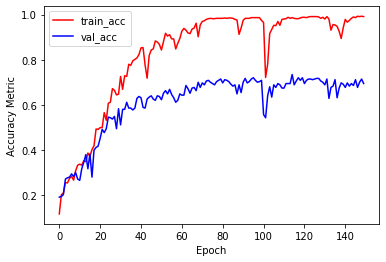

In [16]:
epochs = range(150)
plt.plot(epochs, training_accuracy, color='r', label='train_acc')
plt.plot(epochs, validation_accuracy, color='b', label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Metric')
plt.legend()
plt.show()

### LOSS COMPARISION

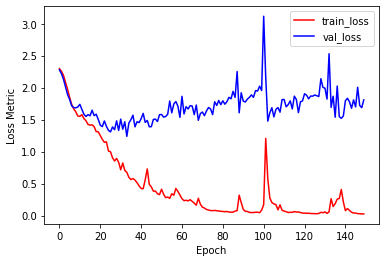

In [17]:
plt.plot(epochs, training_loss, color='r', label='train_loss')
plt.plot(epochs, validation_loss, color='b', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Metric')
plt.legend()
plt.show()

AS AMONG ALL THE MODELS (ANN INCLUDED), THE BEST ONE THAT WORKED WAS LOGISTIC REGRESSION, WE SHALL EXPORT THAT AND MAKE A SCRIPT TO IMPORT THE MODEL AND CLASSIFY AN AUDIO FILE

### ***EXPORTING***

In [48]:
import pickle

final_model = LogisticRegression(max_iter = 1000, C= 10, penalty= 'l2', solver= 'newton-cg')
final_model.fit(mm_X_train, Y_train)

model_file = open('logistic_classifier', 'ab')
scaler_file = open('minmax_scaler', 'ab')
      
pickle.dump(final_model, model_file)
pickle.dump(scaler1, scaler_file)
model_file.close()

### ***FUNCTION TO READ AND CLASSIFY A FILE***

In [49]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import librosa

scaler_file = open('minmax_scaler', 'rb')     
scaler = pickle.load(scaler_file)

predictor_file = open('logistic_classifier', 'rb')
predictor = pickle.load(predictor_file)

def music_classification(filepath):
    audio, sample_rate = librosa.load(filepath)
    features_list = []

    features = librosa.feature.mfcc(y=audio, sr = sample_rate, n_mfcc= 30)
    averaged_features = np.mean(features, axis=1)
    variance_features = np.var(features, axis=1)
    features_list.extend(averaged_features)
    features_list.extend(variance_features)

    tempo_beat = librosa.beat.beat_track(y=audio, sr = sample_rate)
    tempo = tempo_beat[0]
    beat_mean = np.mean(tempo_beat[1])
    beat_var = np.var(tempo_beat[1])
    features_list.append(tempo)
    features_list.append(beat_mean)
    features_list.append(beat_var)

    onset = librosa.onset.onset_strength(y=audio, sr = sample_rate)
    averaged_onset = np.mean(onset)
    variance_onset = np.var(onset)
    features_list.append(averaged_onset)
    features_list.append(variance_onset)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr = sample_rate)
    averaged_mel = np.mean(mel_spectrogram, axis = 1)
    variance_mel = np.var(mel_spectrogram, axis = 1)
    features_list.extend(averaged_mel)
    features_list.extend(variance_mel)

    chroma_cens = librosa.feature.chroma_cens(y=audio, sr = sample_rate)
    averaged_cens = np.mean(chroma_cens, axis = 1)
    variance_cens = np.var(chroma_cens, axis = 1)
    features_list.extend(averaged_cens)
    features_list.extend(variance_cens)

    chroma_cqt = librosa.feature.chroma_cqt(y=audio, sr = sample_rate)
    averaged_cqt = np.mean(chroma_cqt, axis = 1)
    variance_cqt = np.var(chroma_cqt, axis = 1)
    features_list.extend(averaged_cqt)
    features_list.extend(variance_cqt)

    chroma_stft = librosa.feature.chroma_stft(y=audio, sr = sample_rate)
    averaged_stft = np.mean(chroma_stft, axis = 1)
    variance_stft = np.var(chroma_stft, axis = 1)
    features_list.extend(averaged_stft)
    features_list.extend(variance_stft)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr = sample_rate)
    averaged_rolloff = np.mean(spectral_rolloff, axis = 1)
    variance_rolloff = np.var(spectral_rolloff, axis = 1)
    features_list.extend(averaged_rolloff)
    features_list.extend(variance_rolloff)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr = sample_rate)
    averaged_bandwidth = np.mean(spectral_bandwidth, axis = 1)
    variance_bandwidth = np.var(spectral_bandwidth, axis = 1)
    features_list.extend(averaged_bandwidth)
    features_list.extend(variance_bandwidth)

    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr = sample_rate)
    averaged_contrast = np.mean(spectral_contrast, axis = 1)
    variance_contrast = np.var(spectral_contrast, axis = 1)
    features_list.extend(averaged_contrast)
    features_list.extend(variance_contrast)

    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr = sample_rate)
    averaged_centroid = np.mean(spectral_centroid, axis = 1)
    variance_centroid = np.var(spectral_centroid, axis = 1)
    features_list.extend(averaged_centroid)
    features_list.extend(variance_centroid)

    spectral_flatness = librosa.feature.spectral_flatness(y=audio)
    averaged_flatness = np.mean(spectral_flatness, axis = 1)
    variance_flatness = np.var(spectral_flatness, axis = 1)
    features_list.extend(averaged_flatness)
    features_list.extend(variance_flatness)

    features_list = scaler1.transform([features_list])

    print(predictor.predict(features_list))
music_classification('Data/genres_original/blues/blues.00001.wav')

['blues']


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### ***CONFUSION MATRIX (CLASSIFICATION METRIC)***

Index-0: blues
Index-1: classical
Index-2: country
Index-3: disco
Index-4: hiphop
Index-5: jazz
Index-6: metal
Index-7: pop
Index-8: reggae
Index-9: rock


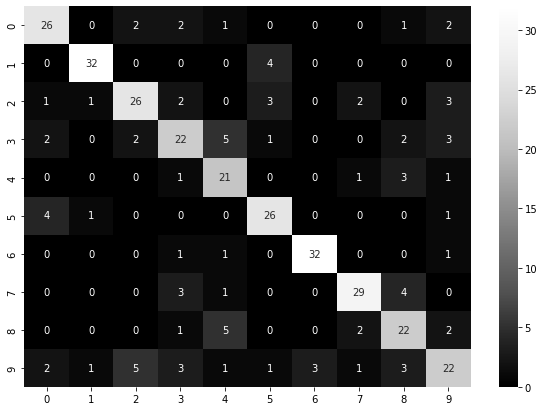

In [69]:
predictions = predictor.predict(mm_X_test)

labels = sorted(np.unique(predictions))
predictions_index = [labels.index(i) for i in predictions]
actual_index = [labels.index(i) for i in Y_test]

for i in range(len(labels)):
    print('Index-{}: {}'.format(i, labels[i]))
plt.figure(figsize = (10, 7))
sns.heatmap(data = confusion_matrix(predictions_index, actual_index), cmap = 'Greys_r', annot = True)
plt.show()